## Training the Neural Network

Importing the required packages

In [1]:
from astropy.table import Table
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
from time import time
from sklearn.preprocessing import StandardScaler, RobustScaler
import pandas as pd
from gaiaxpy import generate, PhotometricSystem

Converting to GPU if available

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Checking directory

In [3]:
%%bash
cd /scratch/
pwd

/scratch


loading initial variables, being how the data is scaled, batchsize, learning rate, number of epochs, optimization algorithm, loss function, and dataset

In [4]:
# scalers for dataloading
metscaler = RobustScaler()
logscaler = RobustScaler()
tefscaler = RobustScaler()
amscaler = RobustScaler()
scale = 'Robust_Custom'

batchlen = 32
lr = 1e-3
epochs = 10
optimize = 'Adam'
datafname = '/arc/home/aydanmckay/filtered_apogee_bprp_gmag.h5'
datashort = 'filtered_apogee_resnet_no_do'
# edited in training loop as well.
lossname = 'log'

Defining the dataset classes. train_set and valid_set are no longer used.

In [5]:
# defining the Dataset class
class data_set(Dataset):
    '''
    Main way to access the .h5 file.
    '''
    def __init__(self,file,train=True,valid=False,test=False,noscale=False):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        if train:
            dset = self.f['group_1']['data']
            d = dset[:]
            dat = np.array([
                metscaler.fit_transform(d[[0]].T).flatten(),
                logscaler.fit_transform(d[[1]].T).flatten(),
                tefscaler.fit_transform(d[[2]].T).flatten(),
                amscaler.fit_transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif valid:
            dset = self.f['group_2']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif test:
            dset = self.f['group_3']['data']
            d = dset[:]
            dat = np.array([
                metscaler.transform(d[[0]].T).flatten(),
                logscaler.transform(d[[1]].T).flatten(),
                tefscaler.transform(d[[2]].T).flatten(),
                amscaler.transform(d[[3]].T).flatten(), # comment out if not
            ])
            self.l = dat.shape[1]
            self.x = torch.Tensor(dat.T)
        elif noscale:
            dset = self.f['group_3']['data']
            d = dset[:]
            self.l = d.shape[1]
            self.x = torch.Tensor(d.T)
        
        # get label
        if train:
            ydset = self.f['group_1']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat[:].T) # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        elif valid:
            ydset = self.f['group_2']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat[:].T)
        elif test:
            ydset = self.f['group_3']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat[:].T)
        elif noscale:
            ydset = self.f['group_3']['label']
            ydat = ydset[:]
            self.y = torch.Tensor(ydat.T)
        
        
        # get error in label # comment out for non-error label runs
        if train:
            errdset = self.f['group_1']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif valid:
            errdset = self.f['group_2']['e_label']
            self.err = torch.Tensor(errdset[:].T)
        elif test or noscale:
            errdset = self.f['group_3']['e_label']
            self.err = torch.Tensor(errdset[:].T)
            
        # bpnews = np.array(ydat[:55]).T
        # rpnews = np.array(ydat[55:]).T
        # df = pd.DataFrame(
        #     {'source_id':range(len(ydat.T)),
        #      'bp_coefficients':list(bpnews),
        #      'bp_standard_deviation':[np.std(bp) for bp in bpnews],
        #      'bp_coefficient_covariances':[np.zeros((55,55)) for _ in bpnews],
        #      'rp_coefficients':list(rpnews),
        #      'rp_coefficient_covariances':[np.zeros((55,55)) for _ in bpnews],
        #      'rp_standard_deviation':[np.std(rp) for rp in rpnews]
        #     }
        # )
        # synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
        # self.g = torch.from_numpy(synthetic_photometry['Pristine_mag_CaHK'].to_numpy(dtype='float32'))
        
        if train:
            errdset = self.f['group_1']['gmag']
            self.g = torch.Tensor(errdset[:].T)
        elif valid:
            errdset = self.f['group_2']['gmag']
            self.g = torch.Tensor(errdset[:].T)
        elif test or noscale:
            errdset = self.f['group_3']['gmag']
            self.g = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.l
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        gg = self.g[index]
        errg = self.err[index]
        return (xg,yg,gg,errg)

Defining networks

In [6]:
class ResBlock(nn.Module):
    '''
    check this guy out, might not be using sigmoid when I should be.
    '''
    def __init__(self, nodes):
        super(ResBlock, self).__init__()
        self.res_block1 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
            nn.LeakyReLU(),
            # nn.Sigmoid(),
        )
        self.res_block2 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
        )
        self.lrelu = nn.LeakyReLU()
        self.siggy = nn.Sigmoid()
#         add dropout in the init
        self.do = nn.Dropout() #
    
    def forward(self, x):
        res = x
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x + res
        output = self.lrelu(x)
        # output = self.siggy(x)
#         add dropout after the relu
        # output = self.do(x) #
        return output
        
class ResNetM(nn.Module):
    def __init__(self):
        super(ResNetM, self).__init__()
        self.input_block = nn.Sequential(
            nn.Linear(4,16),
            nn.LeakyReLU(),
        )
        self.blocklist = nn.ModuleList([
            ResBlock(16),
            ResBlock(16),
            nn.Linear(16,32),
            ResBlock(32),
            ResBlock(32),
            nn.Linear(32,64),
            ResBlock(64),
            ResBlock(64),
            nn.Linear(64,128),
            ResBlock(128),
            ResBlock(128),
        ])
        self.output_block = nn.Sequential(
            nn.Linear(128,110),
        )
        
    def forward(self,x):
        x = self.input_block(x)
        for i, _ in enumerate(self.blocklist):
            x = self.blocklist[i](x)
        logits = self.output_block(x)
        return logits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(4, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 110),
            # nn.Linear(128,110),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# try 3-layer simple network with sigmoid

Accessing datasets

In [7]:
training_data = data_set(datafname)
valid_data = data_set(datafname,train=False,valid=True)

Creating dataloaders

In [8]:
train_dataloader = DataLoader(
    training_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=batchlen,
    shuffle=True,
    num_workers=0
)
# add gaussian noise to data

Selecting a model

In [9]:
model = ResNetM()
# model = Net()
model = model.to(device)

Choosing the loss function

In [10]:
if lossname == 'L1':
    loss_fn = nn.L1Loss()
elif lossname == 'L2':
    loss_fn = nn.MSELoss()
elif lossname == 'Gauss':
    loss_fn = nn.GaussianNLLLoss()
elif lossname == 'Custom':
    tone_map = lambda H, mu=5000000: torch.log(1+mu*abs(H))/np.log(1+mu) # Chi+2023
    loss_fn = lambda pred, true: torch.sum(torch.square(tone_map(true) - tone_map(pred)))
elif lossname == 'log':
    loss_fn = lambda pred, true: torch.sum(torch.square(torch.log(abs(true) + 1e-5) - torch.log(abs(pred) + 1e-5)))

selecing the optimizaition algorithm

In [11]:
if optimize == 'SGD':
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        # weight_decay=1e-1
    )
    # weight decay -> 1e-1, 1e-3, 1e-5
elif optimize == 'Adam':
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr
    )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=5,
    gamma=0.1
)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     'min'
# )

Train and Validation functions

In [12]:
# normalize = lambda x, n: x / (10 ** (8.5 - n / 2.5))
# normalize = lambda x, n: x / (10 ** (8.5 - 15.5 / 2.5))
# normalize = lambda x, n: torch.log(x)

def train(dataloader, model, loss_fn, optimizer, scheduler, device):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    losses = []
    for batch, (X, y, g, z) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        g = g.to(device)
        # z = z.to(device)
        
        # Y = normalize(y.T, g).T
        
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        losses.append(loss.item())

        if (batch % 1000 == 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {running_loss/(batch+1):>7f}  [{current:>5d}/{size:>5d}]")
        
    scheduler.step()
            
    print(f"loss: {running_loss/len(dataloader):>7f}  [{size:>5d}/{size:>5d}]")
    plt.plot(np.arange(0,len(losses)),losses)
    plt.xlabel('Batch')
    plt.ylabel('Loss ('+lossname+')')
    plt.show()
    return running_loss/len(dataloader)

def valid(dataloader, model, loss_fn, epoch, device, plots = False):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    preds = []
    with torch.no_grad():
        for X, y, g, z in dataloader:
            X = X.to(device)
            y = y.to(device)
            g = g.to(device)
            # z = z.to(device)
            
            # Y = normalize(y.T, g).T
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred == y).type(torch.float).sum().item()
            if plots == True:
                for prediction in pred:
                    preds.append(prediction.to('cpu'))
    
    if plots == True:
        preds = np.array(preds)
        # res(preds,dataloader,epoch,resi='res')
        # res(preds,dataloader,epoch,resi='rel')
        # res(preds,dataloader,epoch,resi='err')
        diagplot(preds,dataloader,epoch)
    
    valid_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>8f}%, Avg loss: {valid_loss:>8f} \n")
    return valid_loss

Train and validation loop for the NN

Epoch 1
-------------------------------
loss: 46145.585938  [    0/277344]
loss: 24341.426188  [32000/277344]
loss: 21507.627319  [64000/277344]
loss: 20195.777814  [96000/277344]
loss: 19469.942378  [128000/277344]
loss: 18985.635251  [160000/277344]
loss: 18489.829791  [192000/277344]
loss: 18022.548699  [224000/277344]
loss: 17655.876329  [256000/277344]
loss: 17493.228768  [277344/277344]


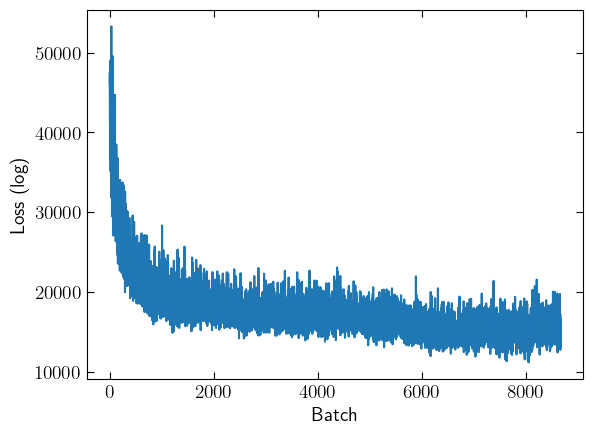

Test Error: 
 Accuracy: 0.000000%, Avg loss: 15051.949625 

Elapsed epoch time: 123.63 s
Epoch 2
-------------------------------
loss: 15122.985352  [    0/277344]
loss: 14685.111895  [32000/277344]
loss: 14814.843172  [64000/277344]
loss: 14641.432495  [96000/277344]
loss: 14849.012124  [128000/277344]
loss: 14764.310883  [160000/277344]
loss: 14723.398387  [192000/277344]
loss: 14602.553086  [224000/277344]
loss: 14454.220546  [256000/277344]
loss: 14274.705927  [277344/277344]


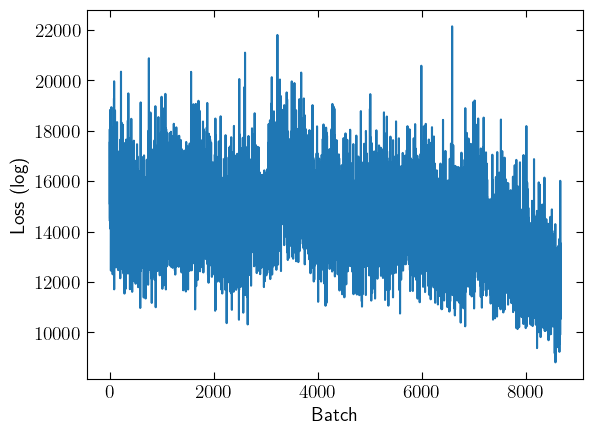

Test Error: 
 Accuracy: 0.000000%, Avg loss: 11968.382222 

Elapsed epoch time: 130.73 s
Epoch 3
-------------------------------
loss: 12323.651367  [    0/277344]
loss: 11569.833881  [32000/277344]
loss: 11500.922090  [64000/277344]
loss: 11306.234416  [96000/277344]
loss: 11172.492757  [128000/277344]
loss: 11395.699717  [160000/277344]
loss: 11726.268090  [192000/277344]
loss: 12038.009133  [224000/277344]
loss: 12255.531409  [256000/277344]
loss: 12437.723953  [277344/277344]


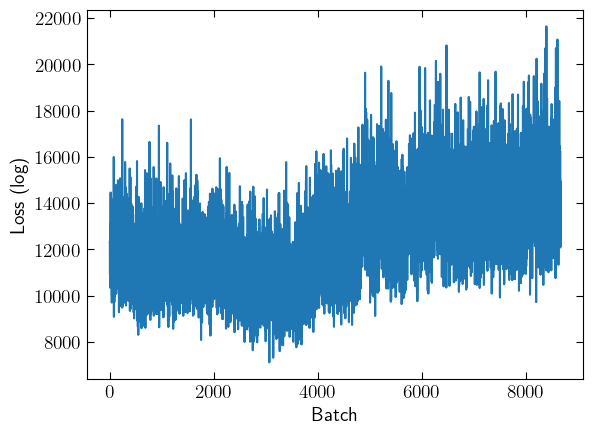

Test Error: 
 Accuracy: 0.000000%, Avg loss: 14782.960626 

Elapsed epoch time: 124.16 s
Epoch 4
-------------------------------
loss: 15424.742188  [    0/277344]
loss: 14249.203247  [32000/277344]
loss: 14094.797596  [64000/277344]
loss: 14632.753216  [96000/277344]
loss: 15141.607112  [128000/277344]
loss: 15235.683378  [160000/277344]
loss: 15367.558633  [192000/277344]
loss: 15413.605528  [224000/277344]
loss: 15408.521483  [256000/277344]
loss: 15444.906258  [277344/277344]


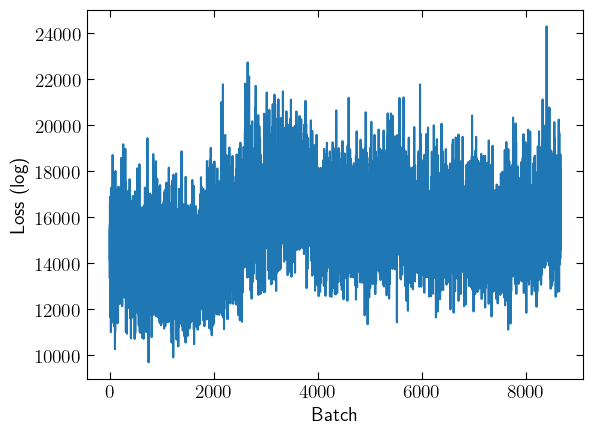

Test Error: 
 Accuracy: 0.000000%, Avg loss: 15655.137368 

Elapsed epoch time: 125.78 s
Epoch 5
-------------------------------
loss: 13597.886719  [    0/277344]
loss: 16235.593287  [32000/277344]
loss: 15974.970490  [64000/277344]
loss: 15840.237424  [96000/277344]
loss: 15750.362477  [128000/277344]
loss: 15681.304861  [160000/277344]
loss: 15639.247384  [192000/277344]
loss: 15579.731775  [224000/277344]
loss: 15500.842437  [256000/277344]
loss: 15469.585999  [277344/277344]


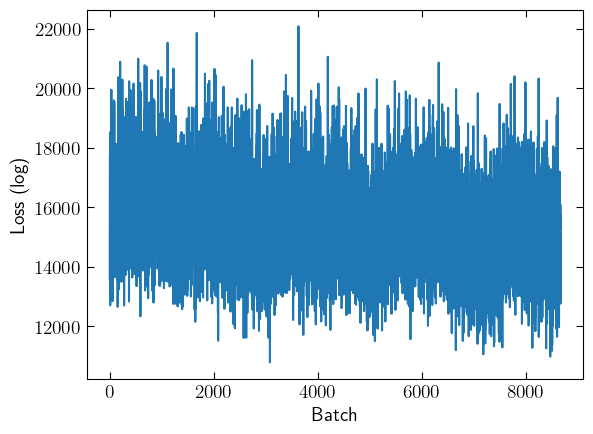

Test Error: 
 Accuracy: 0.000000%, Avg loss: 14677.950963 

Elapsed epoch time: 136.79 s
Epoch 6
-------------------------------
loss: 13185.947266  [    0/277344]
loss: 14756.873806  [32000/277344]
loss: 14597.456532  [64000/277344]
loss: 14559.735357  [96000/277344]
loss: 14443.389100  [128000/277344]
loss: 14292.639743  [160000/277344]
loss: 14128.727578  [192000/277344]
loss: 13951.497953  [224000/277344]
loss: 13785.255729  [256000/277344]
loss: 13678.421670  [277344/277344]


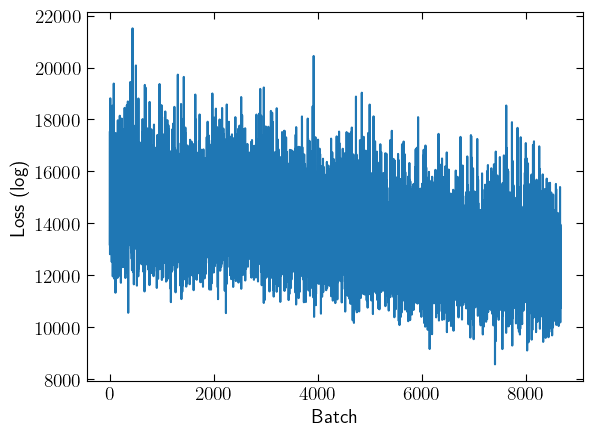

Test Error: 
 Accuracy: 0.000000%, Avg loss: 12228.337595 

Elapsed epoch time: 135.37 s
Epoch 7
-------------------------------
loss: 11099.251953  [    0/277344]
loss: 12197.736953  [32000/277344]
loss: 12088.512263  [64000/277344]
loss: 12010.960970  [96000/277344]
loss: 11914.097958  [128000/277344]
loss: 11842.746976  [160000/277344]
loss: 11771.599234  [192000/277344]
loss: 11702.249419  [224000/277344]
loss: 11651.026623  [256000/277344]
loss: 11636.171913  [277344/277344]


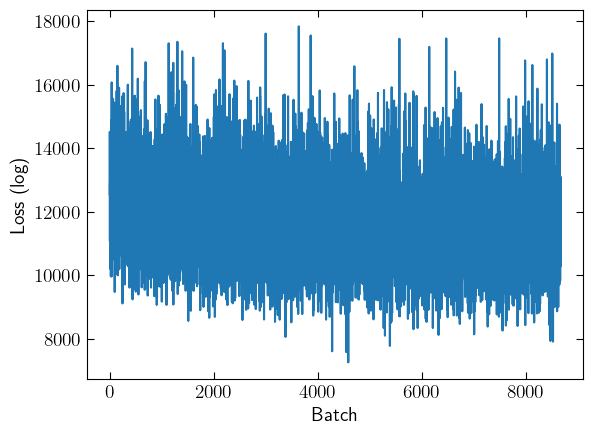

Test Error: 
 Accuracy: 0.003245%, Avg loss: 11484.149705 

Elapsed epoch time: 123.36 s
Epoch 8
-------------------------------
loss: 11476.044922  [    0/277344]
loss: 11432.628395  [32000/277344]
loss: 11454.246239  [64000/277344]
loss: 11416.733720  [96000/277344]
loss: 11372.134407  [128000/277344]
loss: 11342.445560  [160000/277344]
loss: 11323.964269  [192000/277344]
loss: 11309.730497  [224000/277344]
loss: 11303.022877  [256000/277344]
loss: 11297.373201  [277344/277344]


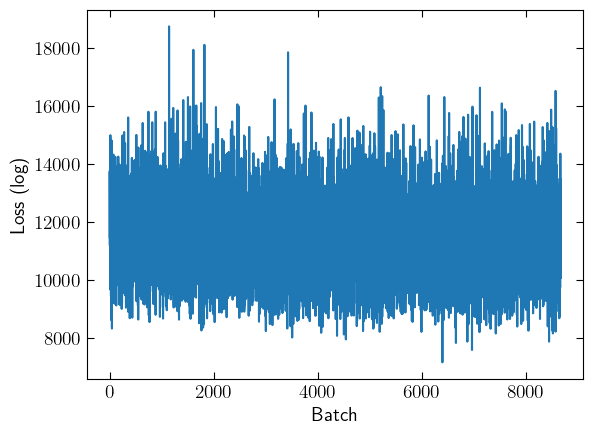

Test Error: 
 Accuracy: 0.000000%, Avg loss: 11102.072039 

Elapsed epoch time: 128.07 s
Epoch 9
-------------------------------
loss: 9894.083984  [    0/277344]
loss: 11161.890889  [32000/277344]
loss: 11085.144724  [64000/277344]
loss: 11066.327018  [96000/277344]
loss: 11080.419260  [128000/277344]
loss: 11058.301943  [160000/277344]
loss: 11067.933755  [192000/277344]
loss: 11085.785396  [224000/277344]
loss: 11095.153987  [256000/277344]
loss: 11093.647919  [277344/277344]


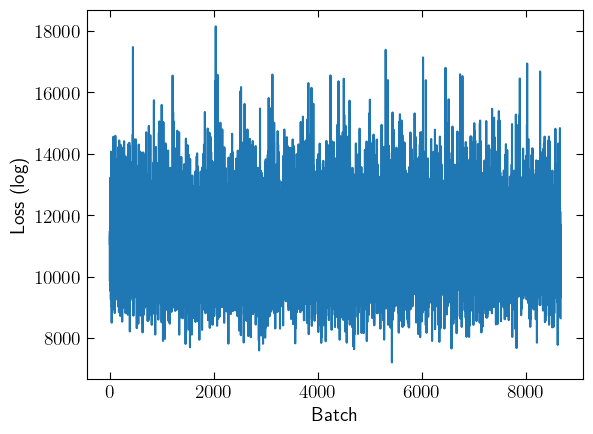

Test Error: 
 Accuracy: 0.000000%, Avg loss: 11016.005495 

Elapsed epoch time: 132.38 s
Epoch 10
-------------------------------
loss: 10399.144531  [    0/277344]
loss: 11081.966007  [32000/277344]
loss: 11116.414442  [64000/277344]
loss: 11066.289985  [96000/277344]
loss: 11046.511211  [128000/277344]
loss: 11035.488929  [160000/277344]
loss: 11034.627935  [192000/277344]
loss: 11028.138003  [224000/277344]
loss: 11017.853277  [256000/277344]
loss: 11014.978961  [277344/277344]


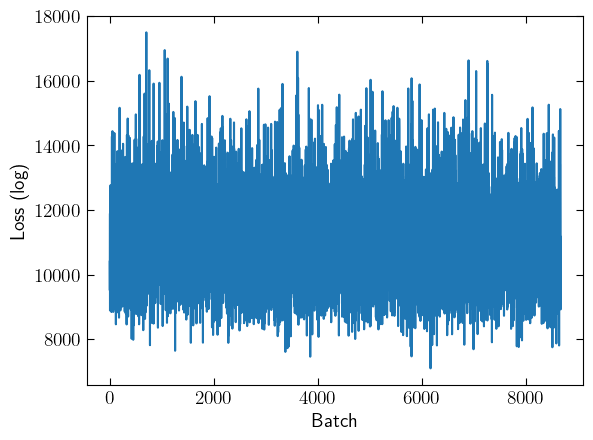

Test Error: 
 Accuracy: 0.000000%, Avg loss: 10862.674442 

Elapsed epoch time: 125.90 s
Training completed


In [13]:
valloss = []
traloss = []
for t in range(epochs):
    t0 = time()
    print(f"Epoch {t+1}\n-------------------------------")
    trainloss = train(
        train_dataloader,
        model,
        loss_fn,
        optimizer,
        scheduler,
        device
    )
    if t % 25 == 0:
        validloss = valid(
            valid_dataloader,
            model,
            loss_fn,
            t,
            device,
            # plots = True,
        )
    else:
        validloss = valid(
            valid_dataloader,
            model,
            loss_fn,
            t,
            device,
        )
    # scheduler.step(validloss)
    valloss.append(validloss)
    traloss.append(trainloss)
    # torch.save({
    #             'epoch': t,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': tloss,
    #             }, '/arc/home/aydanmckay/ml/torchnn/checkpoints/checkpointWGLsmallepoch'+str(t)+'scalecutsep5.pth')
    # torch.save(model.state_dict(), "/arc/home/aydanmckay/torchmodel/torchmodelWsmallscalecutsep5iter"+str(t)+".pth")
    t1 = time()
    print(f'Elapsed epoch time: {t1-t0:.2f} s')
print("Training completed")

plotting the loss of each epoch

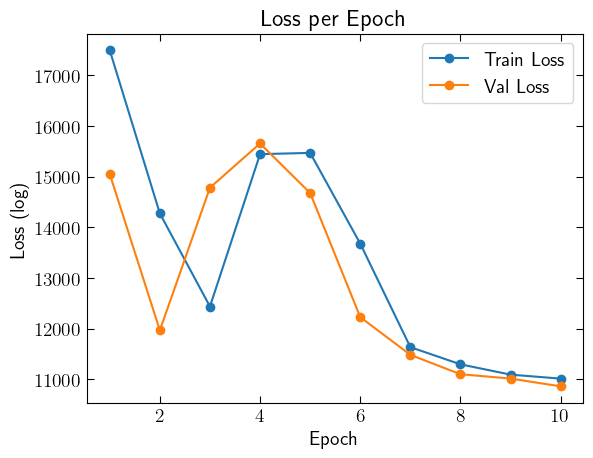

In [14]:
plt.plot(range(1,len(traloss)+1),traloss,'-o',label='Train Loss')
plt.plot(range(1,len(valloss)+1),valloss,'-o',label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss ('+lossname+')')
# plt.ylim(0.65,0.67)
plt.legend(fancybox=True)
plt.title('Loss per Epoch')
plt.savefig('/arc/home/aydanmckay/torchplots/plotloss_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

same but with log axis

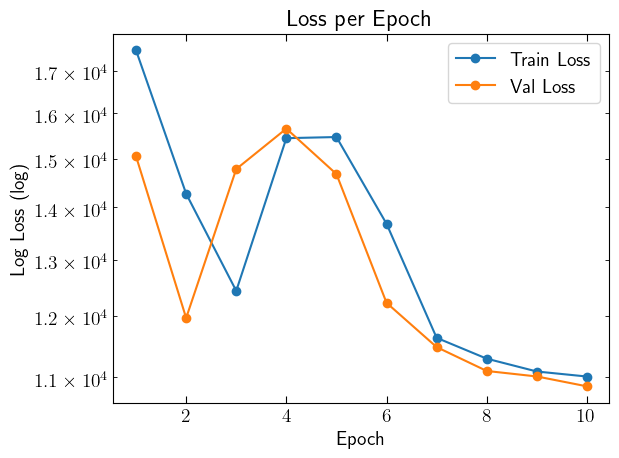

In [15]:
plt.semilogy(range(1,len(traloss)+1),traloss,'-o',label='Train Loss')
plt.semilogy(range(1,len(valloss)+1),valloss,'-o',label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss ('+lossname+')')
# plt.ylim(0.65,0.67)
plt.legend(fancybox=True)
plt.title('Loss per Epoch')
plt.savefig('/arc/home/aydanmckay/torchplots/semilogplotloss_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

saving the trained model

In [16]:
torch.save(model.state_dict(), '/arc/home/aydanmckay/torchmodel/rerun'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.pth')

loading the model to produce the comparison plot

In [17]:
model.load_state_dict(torch.load('/arc/home/aydanmckay/torchmodel/rerun'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.pth'))
model.eval()

ResNetM(
  (input_block): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (blocklist): ModuleList(
    (0): ResBlock(
      (res_block1): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (res_block2): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (lrelu): LeakyReLU(negative_slope=0.01)
      (siggy): Sigmoid()
      (do): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (res_block1): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
    

using the test data and the unscaled test data to see how the model is at predicting the bp/rp parameters. The comparison is done using the synthetic magnitudes so that we can test the fitting of every coefficient at once

plot residuals in reconstructed coeffs, first 3 for sure

In [18]:
test_data = data_set(datafname,train=False,valid=False,test=True,noscale=False)
test_dataloader = DataLoader(
    test_data,
    batch_size=batchlen,
    # shuffle=True,
    num_workers=0
)

putting the data into the correct format for inverse_scaling and gaiaxpy

In [19]:
# unnormalize = lambda x, n: x * (10 ** (8.5 - n / 2.5))
# unnormalize = lambda x, n: x * (10 ** (8.5 - 15.5 / 2.5))
# unnormalize = lambda x, n: np.exp(x+1e-5)

In [20]:
# throw this into a class
def mag_generator(model,loaded_data):
    preds = []
    covbs = []
    covrs = []
    gs = []
    data = []
    with torch.no_grad():
        for X, y, g, z in loaded_data:
            X = X.to(device)
            y = y.to(device)
            g = g.to(device)
            z = z.to(device)
            pred = model(X)
            for prediction,gmag,err,dat in zip(pred,g,z,X):
                covbp = np.zeros((55,55))
                covrp = np.zeros((55,55))
                gs.append(gmag)
                preds.append(prediction)
                data.append(dat)
#                 checking to make sure that the prior errors aren't required for the prediction of magnitude
                # for it in range(len(err[:55])):
                #     covbp[it][it] += err[it].item()**2
                #     covrp[it][it] += err[it+55].item()**2
                covbs.append(covbp)
                covrs.append(covrp)
    preds = np.array([pred.to('cpu').numpy() for pred in preds]).T
    gs = np.array([g.to('cpu').numpy() for g in gs]).T
    data = np.array([dat.to('cpu').numpy() for dat in data]).T
    # xpcoefs = np.array([unnormalize(row,mag) for row,mag in zip(preds.T,gs)]).T

    # bpnews = np.array(xpcoefs[:55]).T
    # rpnews = np.array(xpcoefs[55:]).T
    bpnews = np.array(preds[:55]).T
    rpnews = np.array(preds[55:]).T
    df = pd.DataFrame(
        {'source_id':range(len(preds.T)),
         'bp_coefficients':list(bpnews),
         'bp_standard_deviation':[np.std(bp) for bp in bpnews],
         'bp_coefficient_covariances':covbs,
         'rp_coefficients':list(rpnews),
         'rp_coefficient_covariances':covrs,
         'rp_standard_deviation':[np.std(rp) for rp in rpnews]
        }
    )
    # print(df)
    # synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
    synthetic_photometry = generate(df, photometric_system=PhotometricSystem.SDSS)
    return synthetic_photometry, bpnews, rpnews, data

generating the synthetic magnitudes of the predicted coeffs that were then inverse_scaled

In [21]:
test_synth_phot_preds, test_bp_preds, test_rp_preds, test_data_preds = mag_generator(model,test_dataloader)

In [22]:
test_synth_phot_preds

,source_id,Sdss_mag_u,Sdss_mag_g,Sdss_mag_r,Sdss_mag_i,Sdss_mag_z,Sdss_flux_u,Sdss_flux_g,Sdss_flux_r,Sdss_flux_i,Sdss_flux_z,Sdss_flux_error_u,Sdss_flux_error_g,Sdss_flux_error_r,Sdss_flux_error_i,Sdss_flux_error_z
0,0,16.541568,14.146316,14.137635,NaN,NaN,8.777540e-30,7.970279e-29,8.034259e-29,-1.561860e-28,-2.704902e-28,0.0,0.0,0.0,0.0,0.0
1,1,15.003478,14.046521,14.384346,NaN,NaN,3.619169e-29,8.737591e-29,6.401203e-29,-1.114104e-28,-2.599918e-28,0.0,0.0,0.0,0.0,0.0
2,2,14.950580,14.103768,14.575696,NaN,NaN,3.799864e-29,8.288822e-29,5.366879e-29,-9.162834e-29,-2.333225e-28,0.0,0.0,0.0,0.0,0.0
3,3,15.762286,13.856416,13.821578,NaN,NaN,1.799226e-29,1.040959e-28,1.074902e-28,-2.148281e-28,-3.536559e-28,0.0,0.0,0.0,0.0,0.0
4,4,16.003118,13.901967,13.867630,NaN,NaN,1.441295e-29,9.981898e-29,1.030263e-28,-2.038870e-28,-3.396818e-28,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34236,34236,14.797340,13.935500,14.406179,NaN,NaN,4.375865e-29,9.678322e-29,6.273765e-29,-1.076270e-28,-2.723372e-28,0.0,0.0,0.0,0.0,0.0
34237,34237,15.031095,14.077784,14.418299,NaN,NaN,3.528271e-29,8.489587e-29,6.204126e-29,-1.078498e-28,-2.522524e-28,0.0,0.0,0.0,0.0,0.0
34238,34238,16.521201,14.109943,14.094007,NaN,NaN,8.943752e-30,8.241812e-29,8.363674e-29,-1.629935e-28,-2.805186e-28,0.0,0.0,0.0,0.0,0.0
34239,34239,15.630783,13.782043,13.750224,NaN,NaN,2.030893e-29,1.114763e-28,1.147916e-28,-2.300250e-28,-3.784925e-28,0.0,0.0,0.0,0.0,0.0


putting the unscaled test data into the correct format for gaiaxpy

In [23]:
# # throw this into a class
def mag_generator_unscaled(model,loaded_data):
    preds = []
    data = []
    covbs = []
    covrs = [] 
    with torch.no_grad():
        for X, y, g, z in loaded_data:
            X = X.to(device)
            y = y.to(device)
            z = z.to(device)
            pred = y             
            for prediction,err,dat in zip(pred,z,X):
                covbp = np.zeros((55,55))
                covrp = np.zeros((55,55))
                preds.append(prediction)
                data.append(dat)              
#                 checking to make sure that the prior errors aren't required for the prediction of magnitude
                # for it in range(len(err[:55])):
                    # covbp[it][it] += err[it].item()**2
                    # covrp[it][it] += err[it+55].item()**2
                covbs.append(covbp)
                covrs.append(covrp)
    preds = np.array([pred.to('cpu').numpy() for pred in preds]).T     
    data = np.array([dat.to('cpu').numpy() for dat in data]).T
    bpnews = np.array(preds[:55]).T
    rpnews = np.array(preds[55:]).T
    df = pd.DataFrame(
        {'source_id':range(len(preds.T)),
         'bp_coefficients':list(bpnews),
         'bp_standard_deviation':[np.std(bp) for bp in bpnews],
         'bp_coefficient_covariances':covbs,
         'rp_coefficients':list(rpnews),
         'rp_coefficient_covariances':covrs,
         'rp_standard_deviation':[np.std(rp) for rp in rpnews]
        }
    )
    # synthetic_photometry = generate(df, photometric_system=PhotometricSystem.Pristine)
    synthetic_photometry = generate(df, photometric_system=PhotometricSystem.SDSS)
    return synthetic_photometry, bpnews, rpnews, data

generating the synthetic magnitudes of the true coeffs

In [24]:
test_synth_phot_trues, test_bp_trues, test_rp_trues, test_data_trues = mag_generator_unscaled(model,test_dataloader)

In [25]:
test_synth_phot_trues.describe()

,source_id,Sdss_mag_u,Sdss_mag_g,Sdss_mag_r,Sdss_mag_i,Sdss_mag_z,Sdss_flux_u,Sdss_flux_g,Sdss_flux_r,Sdss_flux_i,Sdss_flux_z,Sdss_flux_error_u,Sdss_flux_error_g,Sdss_flux_error_r,Sdss_flux_error_i,Sdss_flux_error_z
count,34241.00000,34112.000000,34238.000000,34241.000000,34241.000000,34241.000000,3.424100e+04,3.424100e+04,3.424100e+04,3.424100e+04,3.424100e+04,34241.0,34241.0,34241.0,34241.0,34241.0
mean,17120.00000,15.264151,13.543356,12.574346,12.206458,11.989535,1.249283e-28,4.525476e-28,8.284879e-28,1.043048e-27,1.197312e-27,0.0,0.0,0.0,0.0,0.0
std,9884.66962,1.985123,1.800073,1.505760,1.370285,1.296446,3.841956e-28,1.113205e-27,1.575300e-27,1.806547e-27,1.939191e-27,0.0,0.0,0.0,0.0,0.0
min,0.00000,8.552933,7.412068,7.290345,7.289790,7.275802,-7.068606e-31,-3.019968e-32,3.813734e-31,4.350795e-30,1.131089e-29,0.0,0.0,0.0,0.0,0.0
25%,8560.00000,13.911483,12.363704,11.602634,11.330669,11.164733,8.588808e-30,5.070197e-29,1.448060e-28,2.161410e-28,2.754029e-28,0.0,0.0,0.0,0.0,0.0
50%,17120.00000,15.152157,13.379465,12.512987,12.220520,12.043066,3.134490e-29,1.614962e-28,3.587608e-28,4.696690e-28,5.530619e-28,0.0,0.0,0.0,0.0,0.0
75%,25680.00000,16.548671,14.636841,13.498033,13.063157,12.800079,9.849782e-29,4.116030e-28,8.297483e-28,1.065939e-27,1.241958e-27,0.0,0.0,0.0,0.0,0.0
max,34240.00000,25.865806,24.296996,19.946624,17.303578,16.266258,1.376660e-26,3.937068e-26,4.404149e-26,4.406399e-26,4.463537e-26,0.0,0.0,0.0,0.0,0.0


In [26]:
test_synth_phot_trues.describe()

,source_id,Sdss_mag_u,Sdss_mag_g,Sdss_mag_r,Sdss_mag_i,Sdss_mag_z,Sdss_flux_u,Sdss_flux_g,Sdss_flux_r,Sdss_flux_i,Sdss_flux_z,Sdss_flux_error_u,Sdss_flux_error_g,Sdss_flux_error_r,Sdss_flux_error_i,Sdss_flux_error_z
count,34241.00000,34112.000000,34238.000000,34241.000000,34241.000000,34241.000000,3.424100e+04,3.424100e+04,3.424100e+04,3.424100e+04,3.424100e+04,34241.0,34241.0,34241.0,34241.0,34241.0
mean,17120.00000,15.264151,13.543356,12.574346,12.206458,11.989535,1.249283e-28,4.525476e-28,8.284879e-28,1.043048e-27,1.197312e-27,0.0,0.0,0.0,0.0,0.0
std,9884.66962,1.985123,1.800073,1.505760,1.370285,1.296446,3.841956e-28,1.113205e-27,1.575300e-27,1.806547e-27,1.939191e-27,0.0,0.0,0.0,0.0,0.0
min,0.00000,8.552933,7.412068,7.290345,7.289790,7.275802,-7.068606e-31,-3.019968e-32,3.813734e-31,4.350795e-30,1.131089e-29,0.0,0.0,0.0,0.0,0.0
25%,8560.00000,13.911483,12.363704,11.602634,11.330669,11.164733,8.588808e-30,5.070197e-29,1.448060e-28,2.161410e-28,2.754029e-28,0.0,0.0,0.0,0.0,0.0
50%,17120.00000,15.152157,13.379465,12.512987,12.220520,12.043066,3.134490e-29,1.614962e-28,3.587608e-28,4.696690e-28,5.530619e-28,0.0,0.0,0.0,0.0,0.0
75%,25680.00000,16.548671,14.636841,13.498033,13.063157,12.800079,9.849782e-29,4.116030e-28,8.297483e-28,1.065939e-27,1.241958e-27,0.0,0.0,0.0,0.0,0.0
max,34240.00000,25.865806,24.296996,19.946624,17.303578,16.266258,1.376660e-26,3.937068e-26,4.404149e-26,4.406399e-26,4.463537e-26,0.0,0.0,0.0,0.0,0.0


In [27]:
test_synth_phot_preds.describe()

,source_id,Sdss_mag_u,Sdss_mag_g,Sdss_mag_r,Sdss_mag_i,Sdss_mag_z,Sdss_flux_u,Sdss_flux_g,Sdss_flux_r,Sdss_flux_i,Sdss_flux_z,Sdss_flux_error_u,Sdss_flux_error_g,Sdss_flux_error_r,Sdss_flux_error_i,Sdss_flux_error_z
count,34241.00000,34241.000000,34241.000000,34241.000000,0.0,0.0,3.424100e+04,3.424100e+04,3.424100e+04,3.424100e+04,3.424100e+04,34241.0,34241.0,34241.0,34241.0,34241.0
mean,17120.00000,15.465246,14.082523,14.309580,NaN,NaN,2.577034e-29,8.597327e-29,7.335951e-29,-1.377879e-28,-2.694493e-28,0.0,0.0,0.0,0.0,0.0
std,9884.66962,0.466615,0.202069,0.398576,NaN,NaN,9.998677e-30,1.554337e-29,2.683549e-29,5.998911e-29,6.754728e-29,0.0,0.0,0.0,0.0,0.0
min,0.00000,14.608843,13.744538,13.722467,NaN,NaN,6.143878e-30,3.997988e-29,2.912776e-29,-2.341777e-28,-3.894696e-28,0.0,0.0,0.0,0.0,0.0
25%,8560.00000,15.112218,13.900858,13.863892,NaN,NaN,1.616347e-29,7.039034e-29,4.796014e-29,-2.055098e-28,-3.398418e-28,0.0,0.0,0.0,0.0,0.0
50%,17120.00000,15.229100,14.040409,14.443837,NaN,NaN,2.940086e-29,8.786915e-29,6.059896e-29,-1.047430e-28,-2.546539e-28,0.0,0.0,0.0,0.0,0.0
75%,25680.00000,15.878664,14.281217,14.697799,NaN,NaN,3.274256e-29,9.992103e-29,1.033816e-28,-8.197877e-29,-2.027478e-28,0.0,0.0,0.0,0.0,0.0
max,34240.00000,16.928894,14.895396,15.239232,NaN,NaN,5.205502e-29,1.153944e-28,1.177641e-28,-4.910768e-29,-1.192816e-28,0.0,0.0,0.0,0.0,0.0


Plotting the comparison plot

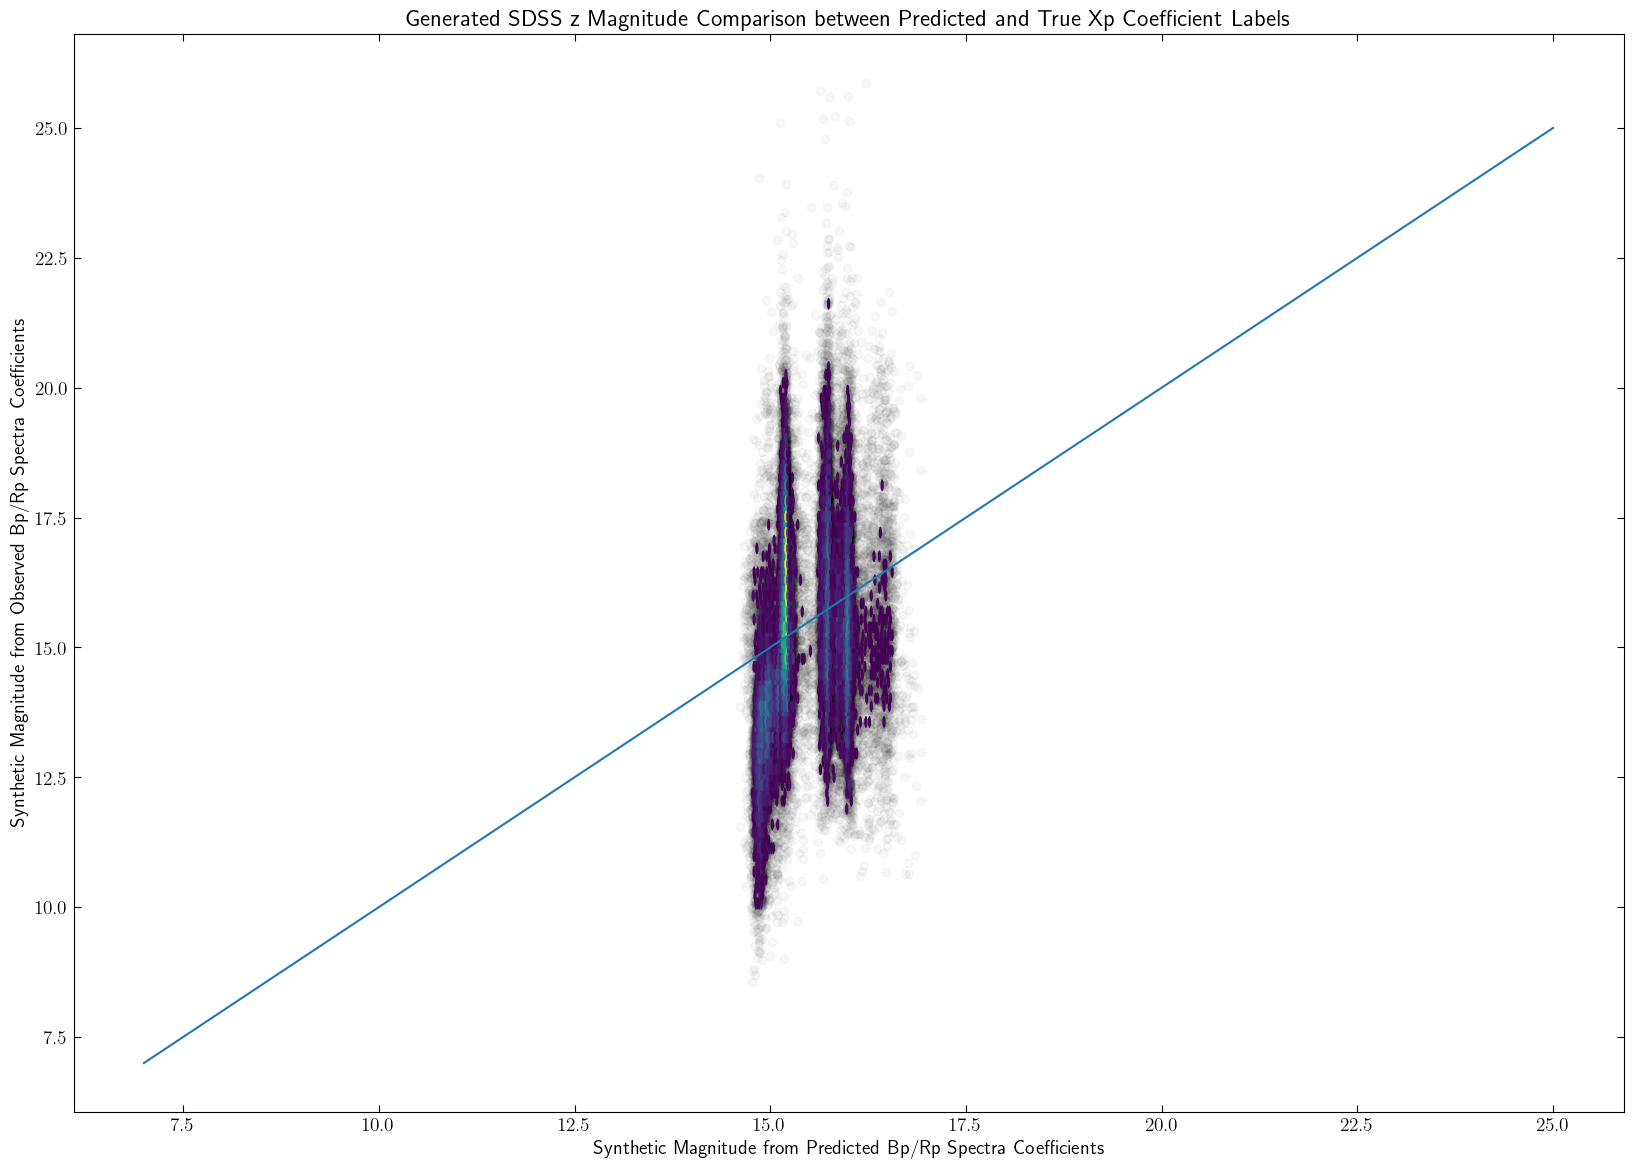

In [28]:
plt.figure(figsize=(20,14))

ax = plt.gca()
# ax.xaxis.set_minor_locator(MultipleLocator(200))
# ax.yaxis.set_minor_locator(MultipleLocator(.2))

# plt.scatter(test_synth_phot_preds['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK'],c='k',alpha=0.03)
# plt.hexbin(test_synth_phot_preds['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK'],mincnt=5)
plt.scatter(test_synth_phot_preds['Sdss_mag_u'],test_synth_phot_trues['Sdss_mag_u'],c='k',alpha=0.03)
plt.hexbin(test_synth_phot_preds['Sdss_mag_u'],test_synth_phot_trues['Sdss_mag_u'],mincnt=5)
plt.plot(np.arange(7,26),np.arange(7,26))
# plt.xlim(13,26)
plt.xlabel('Synthetic Magnitude from Predicted Bp/Rp Spectra Coefficients')
plt.ylabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
# plt.title('Generated Pristine CaHK Magnitude Comparison between Predicted and True Xp Coefficient Labels');
plt.title('Generated SDSS z Magnitude Comparison between Predicted and True Xp Coefficient Labels');
# plt.savefig('/arc/home/aydanmckay/torchplots/testaccuracy_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

Text(0.5, 0, 'Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')

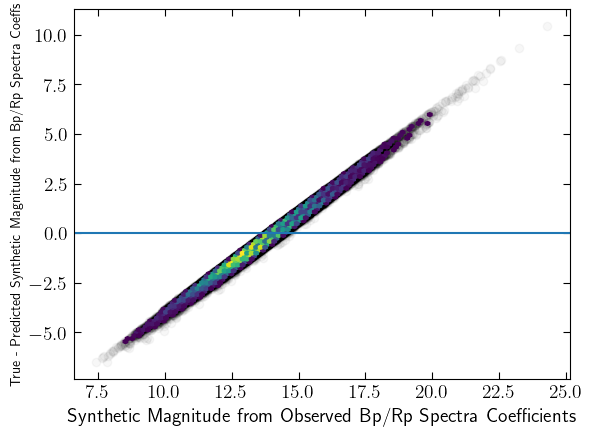

In [29]:
# plt.scatter(test_synth_phot_trues['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK'],c='k',alpha=0.03)
# plt.hexbin(test_synth_phot_trues['Pristine_mag_CaHK'],test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK'],mincnt=5)
plt.scatter(test_synth_phot_trues['Sdss_mag_g'],test_synth_phot_trues['Sdss_mag_g']-test_synth_phot_preds['Sdss_mag_g'],c='k',alpha=0.03)
plt.hexbin(test_synth_phot_trues['Sdss_mag_g'],test_synth_phot_trues['Sdss_mag_g']-test_synth_phot_preds['Sdss_mag_g'],mincnt=5)
plt.axhline()
plt.ylabel('True - Predicted Synthetic Magnitude from Bp/Rp Spectra Coeffs',fontsize=10)
plt.xlabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
# plt.savefig('/arc/home/aydanmckay/torchplots/testresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2],test_data_preds[1],c=abs(test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK']),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals (not [Fe/H])')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

KeyError: 'Pristine_mag_CaHK'

<Figure size 1200x800 with 0 Axes>

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2],test_data_preds[1],c=test_data_preds[0],s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Kiel diagram of stars in data set')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

In [ ]:
mask = abs(test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK']) > 1
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][mask],test_data_preds[1][mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][mask]-test_synth_phot_preds['Pristine_mag_CaHK'][mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($>$1 mag)')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagrambadresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][~mask],test_data_preds[1][~mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][~mask]-test_synth_phot_preds['Pristine_mag_CaHK'][~mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($<$1 mag)')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramgoodresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

In [ ]:
mask = abs(test_synth_phot_trues['Pristine_mag_CaHK']-test_synth_phot_preds['Pristine_mag_CaHK']) > 2
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][mask],test_data_preds[1][mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][mask]-test_synth_phot_preds['Pristine_mag_CaHK'][mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($>$2 mag)')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagrambadresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()
plt.figure(figsize=(12,8))
plt.scatter(test_data_preds[2][~mask],test_data_preds[1][~mask],c=abs(test_synth_phot_trues['Pristine_mag_CaHK'][~mask]-test_synth_phot_preds['Pristine_mag_CaHK'][~mask]),s=1)
plt.colorbar()
plt.xlim(3.3,-3)
plt.ylim(2,-3.3)
plt.xlabel('Teff (Standard Scaled)')
plt.ylabel('log g (Standard Scaled)')
plt.title('Pseudo-Kiel diagram of stars in data set coloured by their predicted Pristine magnitude residuals ($<$2 mag)')
# plt.savefig('/arc/home/aydanmckay/torchplots/testkieldiagramgoodresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')
plt.show()

once the fit is better

get the g mag of all the samples,

plot the distribution of the training sample in g

arc/home/aydanmckay/torchresmodel/trainedmodel_filteredapogeelossL1MLP_Powerbl32lr0.01SGDep2dropout.pth is a model with a decent residual plot but a worse looking accuracy plot when using the filtered apogee and the power transformer

In [ ]:
train2_dataloader = DataLoader(
    training_data,
    batch_size=batchlen,
    shuffle=False,
    num_workers=0
)

train_synth_phot_preds, train_bp_preds, train_rp_preds, train_data_preds = mag_generator(model,train2_dataloader)
train_synth_phot_trues, train_bp_trues, train_rp_trues, train_data_trues = mag_generator_unscaled(model,train2_dataloader)

In [ ]:
plt.figure(figsize=(20,14))

ax = plt.gca()
# ax.xaxis.set_minor_locator(MultipleLocator(200))
# ax.yaxis.set_minor_locator(MultipleLocator(.2))

plt.scatter(train_synth_phot_preds['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK'],c='k',alpha=0.03)
plt.hexbin(train_synth_phot_preds['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK'],mincnt=5)
plt.plot(np.arange(7,26),np.arange(7,26))
# plt.xlim(13,26)
plt.xlabel('Synthetic Magnitude from Predicted Bp/Rp Spectra Coefficients')
plt.ylabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
plt.title('Generated Pristine CaHK Magnitude Comparison between Predicted and True Xp Coefficient Labels');
# plt.savefig('/arc/home/aydanmckay/torchplots/trainaccuracy_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

In [ ]:
plt.scatter(train_synth_phot_trues['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK']-train_synth_phot_preds['Pristine_mag_CaHK'],c='k',alpha=0.03)
plt.hexbin(train_synth_phot_trues['Pristine_mag_CaHK'],train_synth_phot_trues['Pristine_mag_CaHK']-train_synth_phot_preds['Pristine_mag_CaHK'],mincnt=5)
plt.axhline()
plt.ylabel('True - Predicted Synthetic Magnitude from Bp/Rp Spectra Coeffs',fontsize=10)
plt.xlabel('Synthetic Magnitude from Observed Bp/Rp Spectra Coefficients')
# plt.savefig('/arc/home/aydanmckay/torchplots/trainresiduals_'+datashort+'_loss'+lossname+'_'+scale+'_bl'+str(batchlen)+'_lr'+str(lr)+'_'+optimize+'_ep'+str(epochs)+'.png')

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Test Set')
axs[0,0].scatter(test_bp_preds[:,0],test_bp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(test_bp_preds[:,0],test_bp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True BP Coefficient 1')
axs[0,0].set_xlabel('Predicted BP Coefficient 1');
axs[0,1].scatter(test_bp_preds[:,0],test_bp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True BP Coefficient 1')
axs[0,1].set_xlabel('log Predicted BP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(test_bp_preds[:,1],test_bp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(test_bp_preds[:,1],test_bp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True BP Coefficient 2')
axs[1,0].set_xlabel('Predicted BP Coefficient 2');
axs[1,1].scatter(test_bp_preds[:,1],test_bp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True BP Coefficient 2')
axs[1,1].set_xlabel('log Predicted BP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(test_bp_preds[:,2],test_bp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(test_bp_preds[:,2],test_bp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True BP Coefficient 3')
axs[2,0].set_xlabel('Predicted BP Coefficient 3');
axs[2,1].scatter(test_bp_preds[:,2],test_bp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True BP Coefficient 3')
axs[2,1].set_xlabel('log Predicted BP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Test Set')
axs[0,0].scatter(test_rp_preds[:,0],test_rp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(test_rp_preds[:,0],test_rp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True RP Coefficient 1')
axs[0,0].set_xlabel('Predicted RP Coefficient 1');
axs[0,1].scatter(test_rp_preds[:,0],test_rp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True RP Coefficient 1')
axs[0,1].set_xlabel('log Predicted RP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(test_rp_preds[:,1],test_rp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(test_rp_preds[:,1],test_rp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True RP Coefficient 2')
axs[1,0].set_xlabel('Predicted RP Coefficient 2');
axs[1,1].scatter(test_rp_preds[:,1],test_rp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True RP Coefficient 2')
axs[1,1].set_xlabel('log Predicted RP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(test_rp_preds[:,2],test_rp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(test_rp_preds[:,2],test_rp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True RP Coefficient 3')
axs[2,0].set_xlabel('Predicted RP Coefficient 3');
axs[2,1].scatter(test_rp_preds[:,2],test_rp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True RP Coefficient 3')
axs[2,1].set_xlabel('log Predicted RP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Train Set')
axs[0,0].scatter(train_bp_preds[:,0],train_bp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(train_bp_preds[:,0],train_bp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True BP Coefficient 1')
axs[0,0].set_xlabel('Predicted BP Coefficient 1');
axs[0,1].scatter(train_bp_preds[:,0],train_bp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True BP Coefficient 1')
axs[0,1].set_xlabel('log Predicted BP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(train_bp_preds[:,1],train_bp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(train_bp_preds[:,1],train_bp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True BP Coefficient 2')
axs[1,0].set_xlabel('Predicted BP Coefficient 2');
axs[1,1].scatter(train_bp_preds[:,1],train_bp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True BP Coefficient 2')
axs[1,1].set_xlabel('log Predicted BP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(train_bp_preds[:,2],train_bp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(train_bp_preds[:,2],train_bp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True BP Coefficient 3')
axs[2,0].set_xlabel('Predicted BP Coefficient 3');
axs[2,1].scatter(train_bp_preds[:,2],train_bp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True BP Coefficient 3')
axs[2,1].set_xlabel('log Predicted BP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(14, 18))
fig.suptitle('Train Set')
axs[0,0].scatter(train_rp_preds[:,0],train_rp_trues[:,0],c='k',alpha=0.1)
axs[0,0].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5)
axs[0,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[0,0].set_ylabel('True RP Coefficient 1')
axs[0,0].set_xlabel('Predicted RP Coefficient 1');
axs[0,1].scatter(train_rp_preds[:,0],train_rp_trues[:,0],c='k',alpha=0.1)
axs[0,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[0,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[0,1].set_ylabel('log True RP Coefficient 1')
axs[0,1].set_xlabel('log Predicted RP Coefficient 1');
axs[0,1].set_yscale('log')
axs[0,1].set_xscale('log')
axs[1,0].scatter(train_rp_preds[:,1],train_rp_trues[:,1],c='k',alpha=0.1)
axs[1,0].hexbin(train_rp_preds[:,1],train_rp_trues[:,1],mincnt=5)
# axs[1,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[1,0].set_ylabel('True RP Coefficient 2')
axs[1,0].set_xlabel('Predicted RP Coefficient 2');
axs[1,1].scatter(train_rp_preds[:,1],train_rp_trues[:,1],c='k',alpha=0.1)
# axs[1,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[1,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[1,1].set_ylabel('log True RP Coefficient 2')
axs[1,1].set_xlabel('log Predicted RP Coefficient 2');
axs[1,1].set_yscale('log')
axs[1,1].set_xscale('log')
axs[2,0].scatter(train_rp_preds[:,2],train_rp_trues[:,2],c='k',alpha=0.1)
axs[2,0].hexbin(train_rp_preds[:,2],train_rp_trues[:,2],mincnt=5)
# axs[2,0].plot(np.arange(0,400000),np.arange(0,400000))
axs[2,0].set_ylabel('True RP Coefficient 3')
axs[2,0].set_xlabel('Predicted RP Coefficient 3');
axs[2,1].scatter(train_rp_preds[:,2],train_rp_trues[:,2],c='k',alpha=0.1)
# axs[2,1].plot(np.arange(0,400000),np.arange(0,400000))
# axs[2,1].hexbin(train_rp_preds[:,0],train_rp_trues[:,0],mincnt=5000)
axs[2,1].set_ylabel('log True RP Coefficient 3')
axs[2,1].set_xlabel('log Predicted RP Coefficient 3');
axs[2,1].set_yscale('log')
axs[2,1].set_xscale('log')
plt.tight_layout()